In [1]:
 from google.colab import drive
drive.mount('/content/gdrive/')

KeyboardInterrupt: ignored

In [0]:
#RUN

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF

import torchvision.datasets as dsets
from skimage import transform
import torchvision.transforms as transforms
import torchvision
from torch.autograd import Variable
import pandas as pd;
import numpy as np;
from torch.utils.data import Dataset, DataLoader
import random;
import math;
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
from torchvision import models
from torch.optim import lr_scheduler
import time
# Visualize the results on PCA-reduced data
from time import time
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [0]:
#Read the images and ground_truth from drive

#RUN

Fold_1 = sio.loadmat('/content/gdrive/My Drive/Licenta/Fold_1.mat')
Fold_2 = sio.loadmat('/content/gdrive/My Drive/Licenta/Fold_2.mat')
Fold_3 = sio.loadmat('/content/gdrive/My Drive/Licenta/Fold_3.mat')
Fold_4 = sio.loadmat('/content/gdrive/My Drive/Licenta/Fold_4.mat')
Fold_5 = sio.loadmat('/content/gdrive/My Drive/Licenta/Fold_5.mat')

fold_1 = Fold_1['Fold_1']
fold_2 = Fold_2['Fold_2']
fold_3 = Fold_3['Fold_3']
fold_4 = Fold_4['Fold_4']
fold_5 = Fold_5['Fold_5']


In [0]:
#RUN
def get_5_fold(index_4, index_1):
    x = [None]*5
    y = [None]*5
    t = [None]*5
    x[0] = fold_1[:,0]
    x[1] = fold_2[:,0]
    x[2] = fold_3[:,0]
    x[3] = fold_4[:,0]
    x[4] = fold_5[:,0]

    y[0] = fold_1[:,1:(512*512)+ 1]
    y[1] = fold_2[:,1:(512*512)+ 1]
    y[2] = fold_3[:,1:(512*512)+ 1]
    y[3] = fold_4[:,1:(512*512)+ 1]
    y[4] = fold_5[:,1:(512*512)+ 1]

    t[0] = fold_1[:,(512*512)+ 1:2*(512*512)+ 1]
    t[1] = fold_2[:,(512*512)+ 1:2*(512*512)+ 1]
    t[2] = fold_3[:,(512*512)+ 1:2*(512*512)+ 1]
    t[3] = fold_4[:,(512*512)+ 1:2*(512*512)+ 1]
    t[4] = fold_5[:,(512*512)+ 1:2*(512*512)+ 1]

    labels_train = np.concatenate([x[index_4[0]], x[index_4[1]], x[index_4[2]], x[index_4[3]]], 0)
    images_train = np.concatenate([y[index_4[0]], y[index_4[1]], y[index_4[2]], y[index_4[3]]], 0)
    masks_train = np.concatenate([t[index_4[0]], t[index_4[1]], t[index_4[2]], t[index_4[3]]], 0)

    labels_test = x[index_1[0]]
    images_test = y[index_1[0]]
    masks_test = t[index_1[0]]
    del x,y,t
    return labels_train, images_train, masks_train, labels_test, images_test, masks_test

In [5]:
#RUN

# Realize 5-fold cross-validation
from itertools import combinations 
  
# Get all combinations of [1, 2, 3, 4, 5] 
# and length 4
comb = combinations([0, 1, 2, 3, 4], 4) 
comb = list(comb)

#Choose a combination from 0..4
ind = 1
res = [ele  for ele in range(5) if ele   not in comb[ind]] 

#Print first 4-fold indexex for train, and 1-fold index for test
print('Indexes for train: ', comb[ind])
print('Index for test', res)

labels_train, images_train, masks_train, labels_test, images_test, masks_test = get_5_fold(comb[ind], res)
#depend on batch_size


Indexes for train:  (0, 1, 2, 4)
Index for test [3]


In [6]:
#RUN
# Choose l1 and l2 depending on batch_size, and 5_fold generation
# batch should divide de size
# Here I hard coded the values for train and test, depending on folders that I have selected for train and test
l = [[2400, 630], [2430, 600], [2460, 570], [2370, 630], [2490, 540]]
l1 = [[1650, 450]]

CHOOSE = l

size_train_loader = CHOOSE[ind][0]
size_test_loader = CHOOSE[ind][1]

labels_train = labels_train[0:size_train_loader]
images_train = images_train[0:size_train_loader, :]
masks_train = masks_train[0:size_train_loader, :]

labels_test = labels_test[0:size_test_loader]
images_test = images_test[0:size_test_loader, :]
masks_test = masks_test[0:size_test_loader, :]

print(labels_train.shape, images_train.shape, masks_train.shape)
print(labels_test.shape, images_test.shape, masks_test.shape)



(2430,) (2430, 262144) (2430, 262144)
(600,) (600, 262144) (600, 262144)


In [0]:
#RUN to permute data
from sklearn.utils import shuffle

shuffle_labels_train, shuffle_images_train, shuffle_mask_train = shuffle(labels_train, images_train, masks_train, random_state=0)
shuffle_labels_test, shuffle_images_test, shuffle_mask_test = shuffle(labels_test, images_test, masks_test, random_state=0)



In [8]:
print(shuffle_labels_train.shape, shuffle_images_train.shape, shuffle_mask_train.shape)


(2430,) (2430, 262144) (2430, 262144)


In [0]:
#RUN
#free RAM, because session will crash
%reset_selective -f Fold_1
%reset_selective -f Fold_2
%reset_selective -f Fold_3
%reset_selective -f Fold_4
%reset_selective -f Fold_5

In [10]:
# Count the number of unique labels in fold
unique, counts = np.unique(shuffle_labels_train, return_counts=True)
uniquee, countss = np.unique(shuffle_labels_test, return_counts=True)
print(counts, countss)


[ 583 1096  751] [124 312 164]


In [0]:
shuffle_labels_train = torch.from_numpy(shuffle_labels_train)
shuffle_images_train = torch.from_numpy(shuffle_images_train)
shuffle_mask_train = torch.from_numpy(shuffle_mask_train)

shuffle_labels_test = torch.from_numpy(shuffle_labels_test)
shuffle_images_test = torch.from_numpy(shuffle_images_test)
shuffle_mask_test = torch.from_numpy(shuffle_mask_test)

In [12]:
#Compute mean and std dev for train set

mean_tr = (shuffle_images_train.float().mean())
std_tr = (shuffle_images_train.float().std())
print(mean_tr, std_tr)

tensor(460.0681) tensor(635.6172)


In [0]:
class BrainDatasetL(Dataset):
    '''Brain Dataset'''
    def __init__(self, t_x, t_y, ratio, size, mean, std, transform=None):
        self.X         = t_x
        self.Y         = t_y
        self.ratio     = ratio
        self.size      = size
        self.transform = transform
        self.mean      = mean
        self.std       = std
    def __len__(self):
        return len(self.X);
      
    def transformm(self, image):

        # Random horizontal flipping
        image = transforms.ToPILImage()(image)
        if random.random() > 0.5:
            image = TF.hflip(image)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            
        if random.random() > 0.5:
            rotation = random.randint(15, 45)
            image = TF.rotate(image, rotation)

        # Transform to tensor
        image = TF.to_tensor(image)
        return image

    
    def __getitem__(self, idx):
        item = self.X[idx];
        label = self.Y[idx];
        #imaginea 512x512 o transform in size x size
        #image 512x512 will become 512/ratio x 512//ratio for optimize memory
        
        item = item.view(-1, 512)
        item = item[0:512:self.ratio,0:512:self.ratio]
                
        item = item.float()
        
        if self.transform == 1:   
          item, mask = self.transformm(np.float32(item.view(-1, self.size)))
        else:
          item = transforms.ToPILImage()(np.float32(item.view(-1, self.size)))
          item = TF.to_tensor(item)
        return (item, label)




In [0]:
#RUN
batch_size = 30
ratio = 4 #how much we reduce from 1 dimension of image. Ex. ratio = 2 => 256x256 image , ratio = 4 => 512x512
size_image = 128 #Dimmension by dividing height and weight to ratio

train_dataset = BrainDatasetL(shuffle_images_train, shuffle_labels_train, ratio, size_image, mean_tr, std_tr, transform = 0)
test_dataset = BrainDatasetL(shuffle_images_test, shuffle_labels_test, ratio, size_image, mean_tr, std_tr, transform = 0)


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           );
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          );
train_loader_1 = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=1,
                                           );
##########


In [84]:
print(net_resnet.layer4[2])
list(net_resnet.layer4[2].children())[:-1]


Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)


[Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False),
 BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False),
 BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net_resnet = models.resnet101(pretrained=True)
net_resnet.fc = nn.Linear(2048, 3)
net_resnet.to(device)


In [103]:
path_load = 'gdrive/My Drive/PML/FEED/' + 'resnet'
net_resnet.load_state_dict(torch.load(path_load))


<All keys matched successfully>

In [104]:

#Alege hiperparametrii, optimizatorul, learning rate-ul

lr = 0.001
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(net_resnet.parameters(), lr=lr)       #SGD optimiser
scheduler = lr_scheduler.ReduceLROnPlateau(optimiser, factor=0.75, patience=3, verbose=True)


def validate():
      correct = 0
      total = 0
      val_loss = 0
      net_resnet.eval()

      print('--------------TEST--------------')
      for i, (images, labels) in enumerate(test_loader):
          images = images.to(device).float()         # Convert torch tensor to Variable: change image from a vector of size 784 to a matrix of 28 x 28
          labels = labels.to(device).long() - 1
        
          images = images.expand(-1, 3, -1, -1) #Because first layer of cnns have 3 channels for input and my image have 1 channel, i expand the input to 3 channels
          images = images.to(device).float()
            
          with torch.no_grad():
            outputs = net_resnet(images)
          loss = criterion(outputs, labels)
          loss_data = loss.data.item()
            
          if np.isnan(loss_data):
              raise ValueError('loss is nan while validating')

          val_loss += loss
          if i%50 == 0:
              print ("iter {}, loss: {}".format( i, loss))

          _, predicted = torch.max(outputs.data, 1)  # Choose the best class from the output: The class with the best score
          
          #print(predicted)
          #print(outputs.data)
          
          total += labels.size(0)                    # Increment the total count
          correct += (predicted == labels).sum()     # Increment the correct count
          
          del images
          del labels
          del loss
          del outputs
          torch.cuda.empty_cache()

      print(val_loss/((i+1)))
      print('Accuracy of the network on test_loader', (100 * correct.detach().cpu().data.item() / total))
      print('Corect: ', correct.detach().cpu().data.item())
      print('Total: ', total)
      print('--------------TEST--------------')
      return (100 * correct / total), (val_loss/((i+1)))
validate()

--------------TEST--------------
iter 0, loss: 0.020694732666015625
iter 50, loss: 0.2710731029510498
iter 100, loss: 0.07152271270751953
iter 150, loss: 0.8781386613845825
iter 200, loss: 0.05446362495422363
iter 250, loss: 0.20603275299072266
iter 300, loss: 0.2783510684967041
iter 350, loss: 0.07553553581237793
iter 400, loss: 0.18699276447296143
iter 450, loss: 0.1311168670654297
iter 500, loss: 0.0643930435180664
iter 550, loss: 0.031781673431396484
tensor(0.2086, device='cuda:0')
Accuracy of the network on test_loader 92.0
Corect:  552
Total:  600
--------------TEST--------------


(tensor(92, device='cuda:0'), tensor(0.2086, device='cuda:0'))

In [0]:
#Train with these layers frozen for a couple of epochs after

child_counter = 0
for child in net_resnet.children():
    if child_counter < 8:
        print ('child ', child_counter, ' was frozen')
        for param in child.parameters():
            param.requires_grad = False
    else:
        print ('child ', child_counter, ' was not frozen')
    child_counter += 1
for child in net_resnet.children():
   for param in child.parameters():
            print(param.requires_grad )

In [0]:
modules = list(net_resnet.children())[:-1]      # delete the last fc layer.
resnet = nn.Sequential(*modules)
resnet

train_features = []
y_train = []
for i, (images, labels) in enumerate(train_loader_1):   # Load a batch of images with its (index, data, class)
        images = images.to(device).float()         # Convert torch tensor to Variable: change image from a vector of size 784 to a matrix of 28 x 28
        labels = labels.to(device).long() - 1
        
        images = images.expand(-1, 3, -1, -1) #Because first layer of cnns have 3 channels for input and my image have 1 channel, i expand the input to 3 channels
        images = images.to(device).float()

        y_train.append(labels.cpu().detach().numpy()[0])
        outputs = resnet(images) 
        outputs = outputs.view(-1) 
        train_features.append(outputs.cpu().detach().numpy())

test_features  = []
y_test = []
for i, (images, labels) in enumerate(test_loader):   # Load a batch of images with its (index, data, class)
        images = images.to(device).float()         # Convert torch tensor to Variable: change image from a vector of size 784 to a matrix of 28 x 28
        labels = labels.to(device).long() - 1
        
        images = images.expand(-1, 3, -1, -1) #Because first layer of cnns have 3 channels for input and my image have 1 channel, i expand the input to 3 channels
        images = images.to(device).float()
        
        y_test.append(labels.cpu().detach().numpy()[0])
        outputs = resnet(images) 
        outputs = outputs.view(-1) 
        test_features.append(outputs.cpu().detach().numpy())

train_features = np.array(train_features)
test_features = np.array(test_features)

In [0]:
print(test_features.shape)
print(train_features.shape)
import collections
resnet


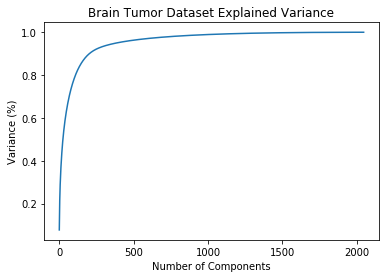

In [108]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(np.concatenate((train_features, test_features), axis = 0))#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Brain Tumor Dataset Explained Variance')
plt.show()

#500 antre
#1500 nea

In [0]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import adjusted_rand_score

kmeans = KMeans(n_clusters=3, max_iter = 600) # You want cluster the passenger records into 2: Survived or Not survived
kmeans.fit(train_features)

y_pred = kmeans.labels_
y_pred_test = kmeans.predict(test_features)

In [0]:
reduced_data = PCA(n_components=500).fit_transform(np.concatenate((train_features, test_features), axis=0))

X_trainn = reduced_data[0:2430,:]
X_testt  = reduced_data[2430:,:]

kmeans1 = KMeans(n_clusters=3, max_iter = 600) # You want cluster the passenger records into 2: Survived or Not survived
kmeans1.fit(X_trainn)

y_pred_PCA = kmeans1.labels_
y_pred_test_PCA = kmeans1.predict(X_testt)

In [111]:
from sklearn.cluster import AgglomerativeClustering

ward1 = AgglomerativeClustering(n_clusters=3, linkage='ward').fit(train_features)
y_pred_H = ward1.labels_

ward2 = AgglomerativeClustering(n_clusters=3, linkage='ward').fit(X_trainn)
y_pred_H_PCA = ward2.labels_


indices = calculate_mapping(y_pred_H, y_train)
print(calculate_accuracy(indices, y_pred_H, y_train))

indices = calculate_mapping(y_pred_H_PCA, y_train)
print(calculate_accuracy(indices, y_pred_H_PCA, y_train))

0.9045267489711935
0.9


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [0]:
def to_codebook(X, part):
    """
    Calculates centroids according to flat cluster assignment

    Parameters
    ----------
    X : array, (n, d)
        The n original observations with d features

    part : array, (n)
        Partition vector. p[n]=c is the cluster assigned to observation n

    Returns
    -------
    codebook : array, (k, d)
        Returns a k x d codebook with k centroids
    """
    codebook = []

    for i in range(part.min(), part.max()+1):
        codebook.append(X[part == i].mean(0))

    return np.vstack(codebook)

In [0]:
hc_clusters_H = to_codebook(train_features, y_pred_H)
hc_clusters_H_PCA = to_codebook(X_trainn, y_pred_H_PCA)

kmeans.cluster_centers_ = hc_clusters_H
y_pred_test_H = kmeans.predict(test_features)

kmeans.cluster_centers_ = hc_clusters_H_PCA
y_pred_test_H_PCA = kmeans.predict(X_testt)

In [0]:
from sklearn.manifold import TSNE

tsne_ter = TSNE(n_components=3, random_state=0, perplexity=40)#, init='pca')
X_tsne_ter = tsne_ter.fit_transform(train_features)
xtsne_t = pd.DataFrame(X_tsne_ter)
X_tsne_test =tsne_ter.fit_transform(test_features)
xtsne_t_test = pd.DataFrame(X_tsne_test)



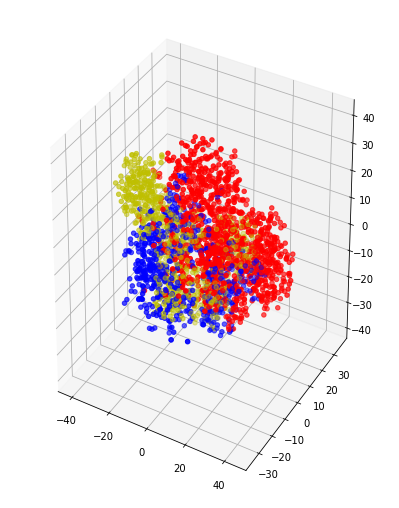

In [115]:
xtsne_t['label'] = y_train

from mpl_toolkits.mplot3d import Axes3D
Axes3D
c_map = {0:'b', 1:'r', 2:'y'}
fig = plt.figure(figsize = (40,20))
ax = fig.add_subplot(251,projection='3d')
ax.scatter(xs=xtsne_t[0],ys=xtsne_t[1],zs=xtsne_t[2], c=[c_map[_] for _ in xtsne_t['label']])
plt.show()

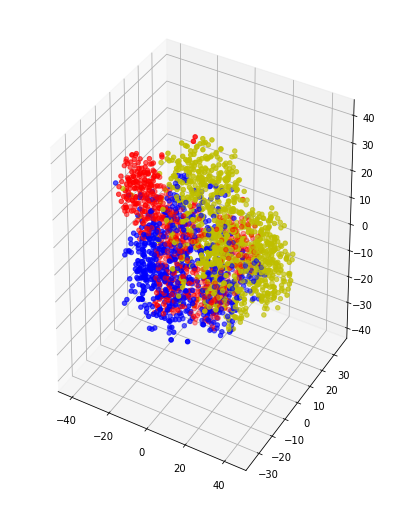

In [116]:
xtsne_t['label'] = y_pred_PCA

from mpl_toolkits.mplot3d import Axes3D
Axes3D
c_map = {0:'b', 1:'r', 2:'y'}

fig = plt.figure(figsize = (40,20))
ax = fig.add_subplot(251,projection='3d')
ax.scatter(xs=xtsne_t[0],ys=xtsne_t[1],zs=xtsne_t[2], c=[c_map[_] for _ in xtsne_t['label']])
plt.show()

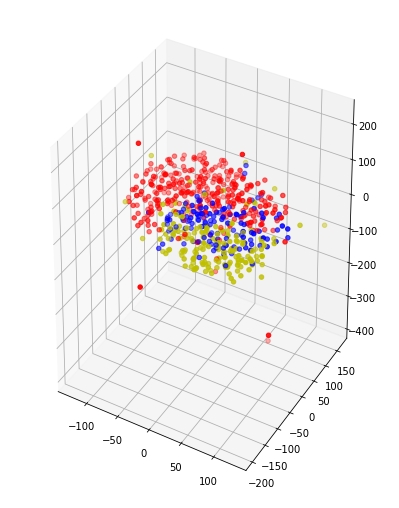

In [117]:
xtsne_t_test['label'] = y_test

from mpl_toolkits.mplot3d import Axes3D
Axes3D
c_map = {0:'b', 1:'r', 2:'y'}
fig = plt.figure(figsize = (40,20))
ax = fig.add_subplot(251,projection='3d')
ax.scatter(xs=xtsne_t_test[0],ys=xtsne_t_test[1],zs=xtsne_t_test[2], c=[c_map[_] for _ in xtsne_t_test['label']])
plt.show()

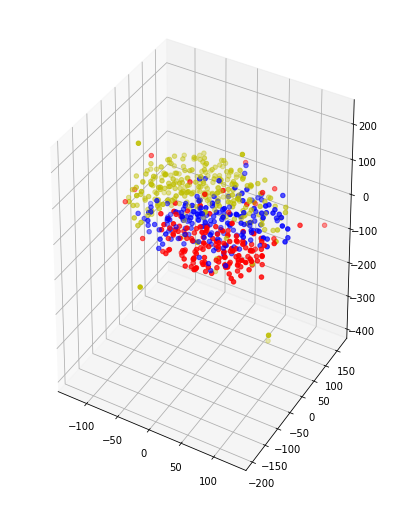

In [118]:
xtsne_t_test['label'] = y_pred_test_PCA

from mpl_toolkits.mplot3d import Axes3D
Axes3D
c_map = {0:'b', 1:'r', 2:'y'}

fig = plt.figure(figsize = (40,20))
ax = fig.add_subplot(251,projection='3d')
ax.scatter(xs=xtsne_t_test[0],ys=xtsne_t_test[1],zs=xtsne_t_test[2], c=[c_map[_] for _ in xtsne_t_test['label']])
plt.show()

In [40]:
# !pip install comb
import numpy as np
from scipy.special import comb
def rand_index_score(clusters, classes):
    tp_plus_fp = comb(np.bincount(clusters), 2).sum()
    tp_plus_fn = comb(np.bincount(classes), 2).sum()
    A = np.c_[(clusters, classes)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)
  
print(rand_index_score(y_train, y_pred))
print(rand_index_score(y_test, y_pred_test))

print(rand_index_score(y_train, y_pred_PCA))
print(rand_index_score(y_test, y_pred_test_PCA))
#GLCM PCA 0.562928303459775 0.6003835768541651 | 0.5632784493538975 0.6012617659676484
#GLRLM PCA 0.5553265249409476 0.5865142453377747 | 0.5553914825621787 0.5865142453377747
#GLCM + GLRLM PCA 0.5590669723495901 0.5987685164155753 | 0.5588536890370988 0.5995457642516466

0.5559353965373818
0.5475848636616584
0.6110414792451295
0.5985141903171953


In [124]:
from scipy.optimize import linear_sum_assignment 
from sklearn.utils.linear_assignment_ import linear_assignment

def calculate_mapping(ypred, y):
    """
    Calculating the clustering accuracy. The predicted result must have the same number of clusters as the ground truth.
    
    ypred: 1-D numpy vector, predicted labels
    y: 1-D numpy vector, ground truth
    The problem of finding the best permutation to calculate the clustering accuracy is a linear assignment problem.
    This function construct a N-by-N cost matrix, then pass it to scipy.optimize.linear_sum_assignment to solve the assignment problem.
    
    """
    assert len(y) > 0
    assert len(np.unique(ypred)) == len(np.unique(y))
    
    s = np.unique(ypred)
    t = np.unique(y)
    
    N = len(np.unique(ypred))
    C = np.zeros((N, N), dtype = np.int32)
    for i in range(N):
        for j in range(N):
            idx = np.logical_and(ypred == s[i], y == t[j])
            C[i][j] = np.count_nonzero(idx)
    
    # convert the C matrix to the 'true' cost
    Cmax = np.amax(C)
    C = Cmax - C
    # 
    indices = linear_assignment(C)
    return indices
def calculate_accuracy(indices, ypred, y):
    
    assert len(y) > 0
    assert len(np.unique(ypred)) == len(np.unique(y))
        
    s = np.unique(ypred)
    t = np.unique(y)

    N = len(np.unique(ypred))

    row = indices[:][:, 0]
    col = indices[:][:, 1]
    # calculating the accuracy according to the optimal assignment
    count = 0
    for i in range(N):
        idx = np.logical_and(ypred == s[row[i]], y == t[col[i]] )
        count += np.count_nonzero(idx)
    
    return 1.0*count/len(y)

indices = calculate_mapping(y_pred, y_train)
print(calculate_accuracy(indices, y_pred, y_train))
print(calculate_accuracy(indices, y_pred_test, y_test))

indices = calculate_mapping(y_pred_PCA, y_train)
print(calculate_accuracy(indices, y_pred_PCA, y_train))
print(calculate_accuracy(indices, y_pred_test_PCA, y_test))

print('---------------------------------------------------')

indices = calculate_mapping(y_pred_H, y_train)
print(calculate_accuracy(indices, y_pred_H, y_train))
print(calculate_accuracy(indices, y_pred_test_H, y_test))

indices = calculate_mapping(y_pred_H_PCA, y_train)
print(calculate_accuracy(indices, y_pred_H_PCA, y_train))
print(calculate_accuracy(indices, y_pred_test_H_PCA, y_test))

#GLCM PCA 0.44583333333333336 0.5285714285714286 | 0.44625 0.5285714285714286
# GLRLM PCA 0.43916666666666665 0.49206349206349204 | 0.4395833333333333 0.
#GLCM + GLRLM 0.44958333333333333 0.5285714285714286 | 0.45125 0.5317460317460317

#feautures resnet  0.922633744855967 0.8616666666666667 | 0.9238683127572016 0.8616666666666667
#features resnet neantrenat 0.4469135802469136 0.435 | 0.4477366255144033 0.435

#antrenat 0.9045267489711935 0.8616666666666667 0.9 0.86
#neantrenat H 0.4683127572016461 0.45166666666666666 | 0.5234567901234568 0.475

0.9222222222222223
0.8616666666666667
0.9222222222222223
0.8616666666666667
---------------------------------------------------
0.9045267489711935
0.8616666666666667
0.9
0.86


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [68]:
import collections
from sklearn.metrics.cluster import normalized_mutual_info_score

print(adjusted_rand_score(y_train, y_pred_PCA))
print(normalized_mutual_info_score(y_train, y_pred_PCA, average_method='geometric'))
print(adjusted_rand_score(y_test, y_pred_test_PCA))
print('-----------------------------------------')
print(accuracy_score(y_train, y_pred_PCA))

print(collections.Counter(y_test))
print(collections.Counter(y_pred_test_PCA))
print(accuracy_score(y_test, y_pred_test_PCA))
print('-----------------------------------------')


print(y_test)
print(y_pred_test)

0.7925258290712719
0.747431240585779
0.6451611683745918
-----------------------------------------
0.01934156378600823
Counter({1: 312, 2: 164, 0: 124})
Counter({0: 260, 2: 177, 1: 163})
0.03166666666666667
-----------------------------------------
[1, 0, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 0, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 2, 0, 1, 2, 2, 2, 2, 0, 1, 0, 1, 1, 0, 2, 0, 0, 2, 1, 2, 2, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 1, 0, 2, 2, 0, 1, 0, 2, 1, 1, 1, 1, 1, 2, 0, 1, 2, 0, 0, 0, 0, 1, 1, 1, 1, 2, 1, 2, 1, 0, 2, 0, 0, 2, 1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 0, 2, 1, 1, 0, 1, 1, 1, 0, 2, 1, 2, 0, 1, 1, 0, 2, 0, 2, 0, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 0, 0, 0, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 0, 1, 2, 0, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 1, 0, 0, 2, 0, 2, 0

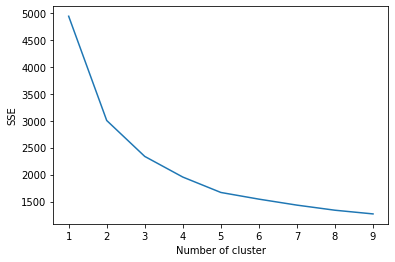

In [0]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=5000).fit(X_train)
    # data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()